<div class="alert alert-block alert-info">
<H2> Notebook Instructions </H2><BR>
1. Press <mark>Shift</mark> + <mark>Enter</mark> to run the cells.<BR>
2. All the Jupyter notebook and data files can be downloaded from the LMS. Please prefix your query with <mark>Support</mark> if you are facing issues in locating the files. If you are watching offline, then reach out to your support manager at <mark>support@quantinsti.com.</mark><BR>
3. If you are new to Jupyter notebook, then read <a href= "https://blog.quantinsti.com/jupyter-notebook-tutorial-installation-components-magic-commands/">this guide</a>.
</div>

## Step 1: Data Setup

In [1]:
import pandas as pd
import warnings
warnings.simplefilter("ignore")
# Define period of backtesting
from datetime import date
start_date = date(2017, 1, 1)
end_date = date(2023, 7, 13)

# Define instrument name
instrument_name = 'LICHSGFIN.NS'

In [2]:
# Fetch Data
from data import get_stock_data
data = get_stock_data(instrument_name,start_date,end_date)
len(data)

[*********************100%***********************]  1 of 1 completed


1614

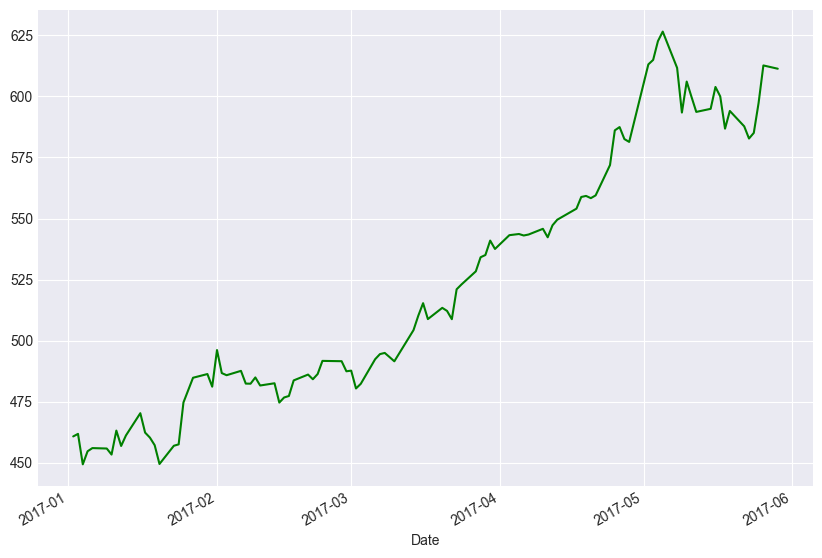

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')
t = 100
data['Close'][:t].plot(figsize=(10,7),color='green')
plt.show()

## Step 2: Defining Alphas

In [4]:
# Alpha 1: MA Cross-Over
from alpha import ma_crossover, compute_adx
import numpy as np
short_lookback = 2
long_lookback = 7

data = ma_crossover(data, short_lookback, long_lookback)

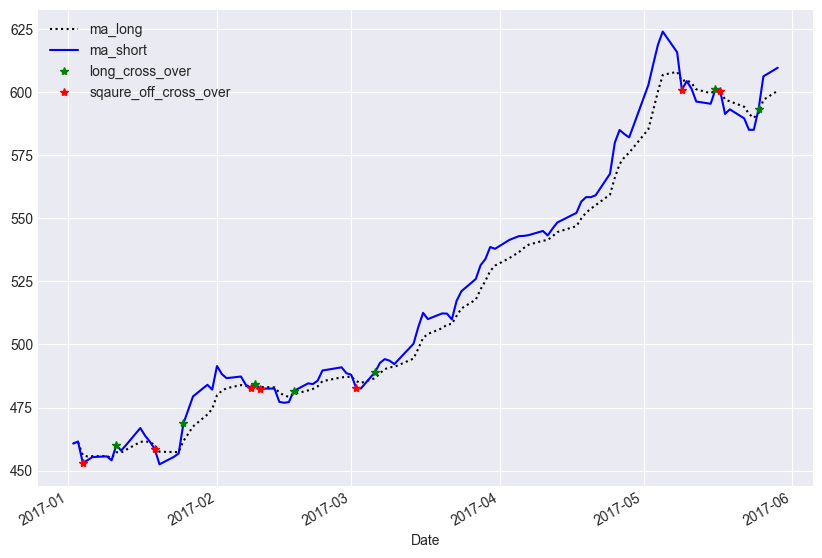

In [5]:
data.ma_long[:t].plot(figsize=(10, 7),style='k:')
data.ma_short[:t].plot(figsize=(10, 7),color='blue')
data['long_cross_over'] = np.where((data.ma_short >= data.ma_long) & (data.ma_short.shift(
    1) < data.ma_long.shift(1)), data.ma_short, np.nan)
data.long_cross_over[:t].plot(style=['g*'], figsize=(10, 7))

data['sqaure_off_cross_over'] = np.where((data.ma_short <= data.ma_long) & (data.ma_short.shift(
    1) > data.ma_long.shift(1)), data.ma_short, np.nan)
data.sqaure_off_cross_over[:t].plot(style=['r*'], figsize=(10, 7))

plt.legend()
plt.show()

In [6]:
data = compute_adx(data, 20)

## Step 3: Analyzing Performance

### Define final signal

In [7]:
#data = data.dropna()
data['signal'] = data['ma_signal'] * data['adx_signal']
data['signal'].fillna(0, inplace=True)

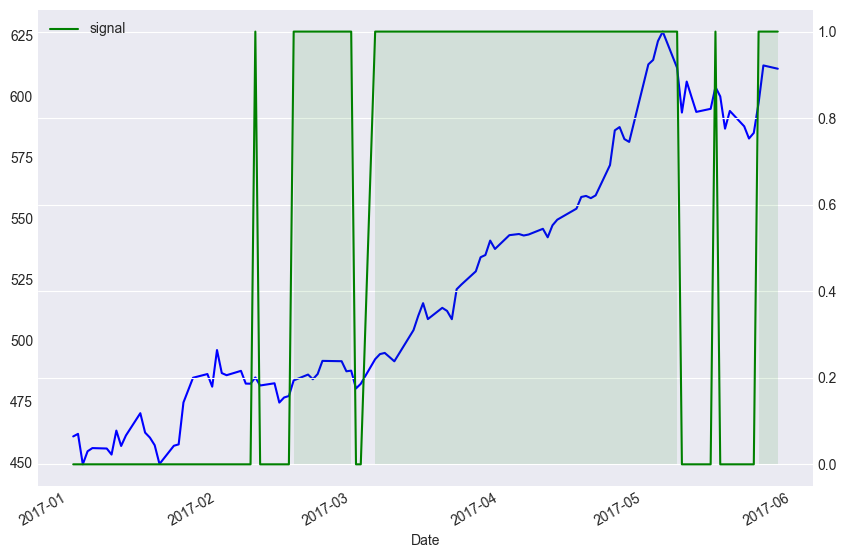

In [8]:
x = 100
data.Close[:t].plot(figsize=(10, 7),color='blue')
data.signal[:t].plot(figsize=(10, 7),secondary_y=True,style='green')
plt.fill_between(data.Close[:t].index, 0, 1,  
                 where=(data.signal[:t]>0) , color = 'green', alpha = 0.1, lw=0)

plt.legend()
plt.show()

### Compute daily returns

In [9]:
from performance_analytics import compute_ret
data = compute_ret(data)

### Daily strategy returns histogram

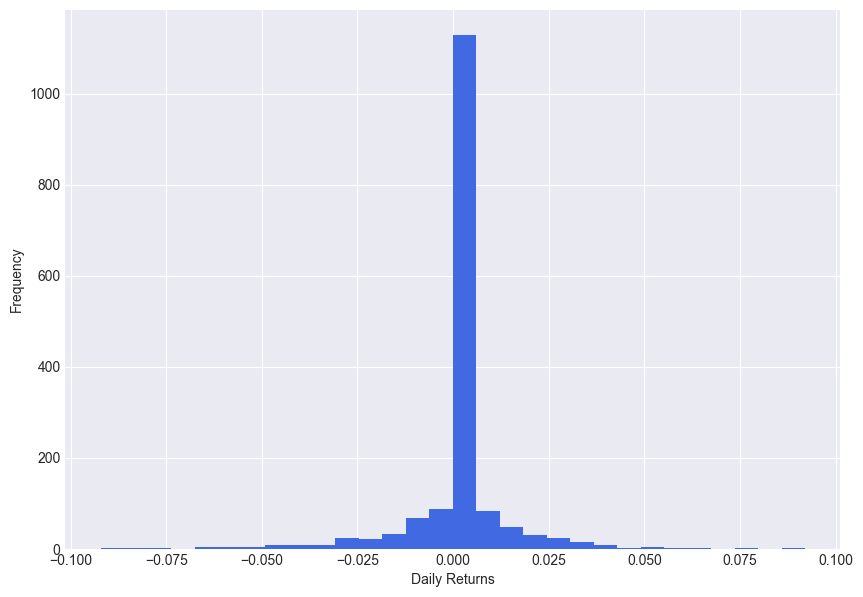

In [10]:
data.strategy_ret.hist(bins=30,figsize=(10,7),color='royalblue')
plt.xlabel('Daily Returns')
plt.ylabel('Frequency')
plt.show()

### Cumulative strategy returns

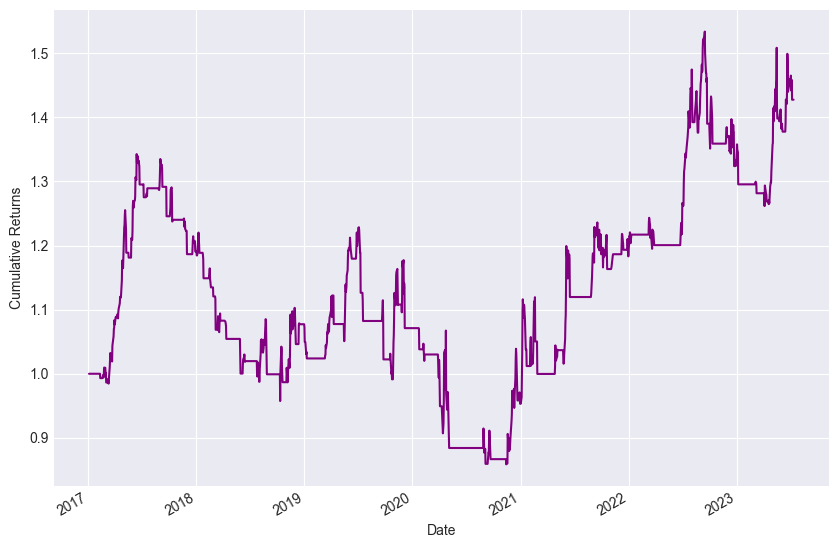

In [11]:
(data.strategy_ret + 1.0).cumprod().plot(figsize=(10,7),color='purple')
plt.ylabel('Cumulative Returns')
plt.show()

## Performance Analysis

Start date,2017-01-02
End date,2023-07-12
Total months,76
,Backtest
Annual return,5.7%
Cumulative returns,42.8%
Annual volatility,20.0%
Sharpe ratio,0.38
Calmar ratio,0.16
Stability,0.13
Max drawdown,-36.0%


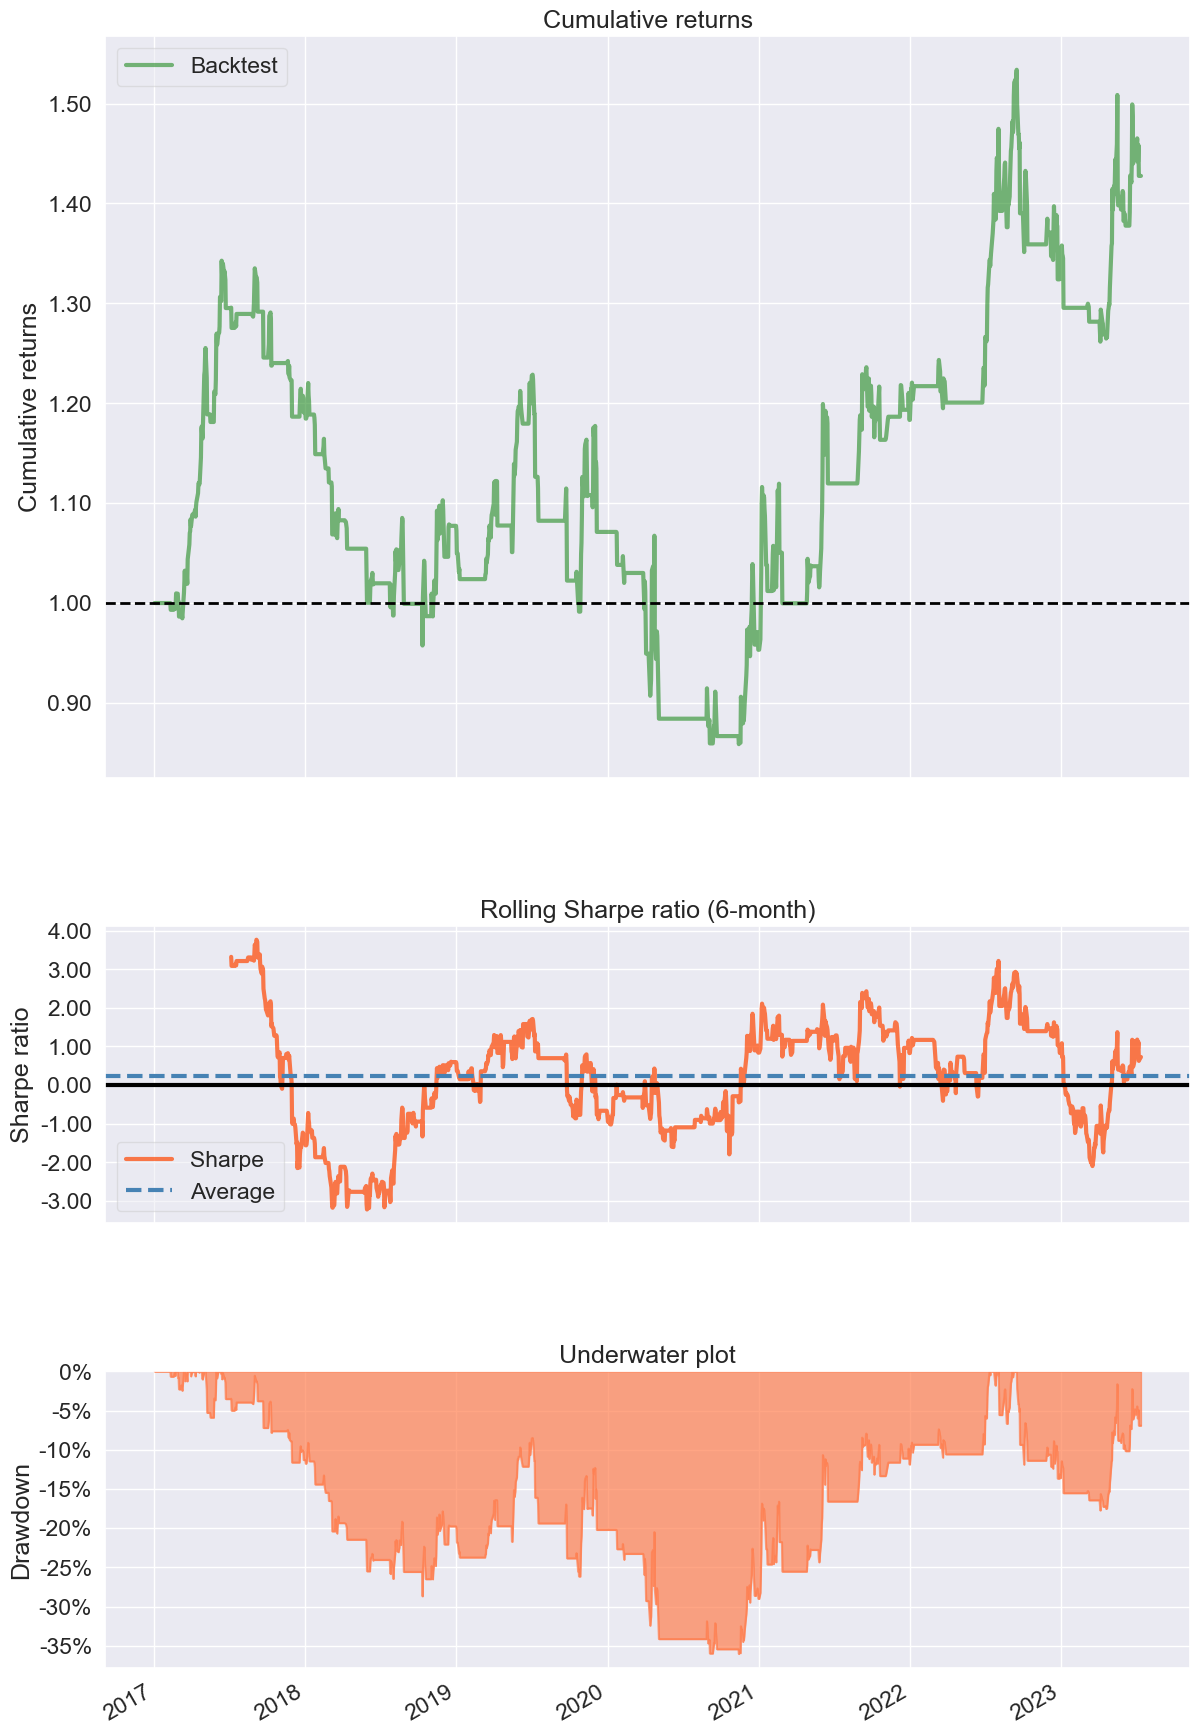

In [12]:
# Uncomment below line to install pyfolio
#!pip install pyfolio
import pyfolio as pf
pf.create_simple_tear_sheet(data.strategy_ret)

# Trade Details

In [13]:
def get_trades(data, close_column, signal_column):
    """Function to generate trade details
    """
    trades = pd.DataFrame()
    current_position = 0
    entry_time = ''

    for i in data.index:

        new_position = data.loc[i, signal_column]

        if new_position != current_position:    

            if entry_time != '':                   
                entry_price = data.loc[entry_time, close_column]
                exit_time = i
                exit_price = data.loc[exit_time, close_column]
                trade_details = pd.DataFrame([(current_position,entry_time, entry_price, exit_time,exit_price)])
                trades = trades.append(trade_details,ignore_index=True)  
                entry_time = ''            

            if new_position != 0:
                entry_time = i
            current_position = new_position


    trades.columns = ['Position','Entry Time','Entry Price','Exit Time','Exit Price']
    trades['PnL'] = (trades['Exit Price'] - trades['Entry Price']) * trades['Position']
    return trades

In [14]:
trades = get_trades(data, 'Close', 'signal')
print('Trade Details')
print('Trade PnL %.2f'% (trades.PnL.sum()))
trades.head()

Trade Details
Trade PnL 165.61


,Position,Entry Time,Entry Price,Exit Time,Exit Price,PnL
0,1.0,2017-02-09,484.902710,2017-02-10,481.599884,-3.302826
1,1.0,2017-02-17,483.685852,2017-03-02,480.383057,-3.302795
2,1.0,2017-03-06,492.377441,2017-05-09,593.416870,101.039429
3,1.0,2017-05-16,603.890259,2017-05-17,600.022522,-3.867737
4,1.0,2017-05-25,597.328186,2017-06-23,654.996704,57.668518


In [15]:
brokerage = 0.03/100
tax = 0.02/100
total_cost = brokerage+tax
total_cost

0.0005

In [16]:
trades.PnL -= total_cost*(trades['Entry Price'] + trades['Exit Price'])
print('Trade Details')
print('Trade PnL Post Tx Cost %.2f'% (trades.PnL.sum()))
trades.head()

Trade Details
Trade PnL Post Tx Cost 131.68


,Position,Entry Time,Entry Price,Exit Time,Exit Price,PnL
0,1.0,2017-02-09,484.902710,2017-02-10,481.599884,-3.786077
1,1.0,2017-02-17,483.685852,2017-03-02,480.383057,-3.784830
2,1.0,2017-03-06,492.377441,2017-05-09,593.416870,100.496532
3,1.0,2017-05-16,603.890259,2017-05-17,600.022522,-4.469693
4,1.0,2017-05-25,597.328186,2017-06-23,654.996704,57.042356


<div class="alert alert-block alert-warning">
    <b>
1. How to reduce the drawdowns?<BR>
2. How to improve the strategy performance?<BR>
        3. How to increase the Sharpe ratio?<BR>
    </b>
</div>